# TMD A12B for specific eta

In [4]:
pip install -U pysr

Note: you may need to restart the kernel to use updated packages.


Julia and Julia dependencies are installed at first import:

In [6]:
import pysr

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Now, let's import everything else as well as the PySRRegressor:


In [8]:
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
import h5py

# PySR for A12B eta = 8:


In [10]:

file_path = "/Users/hariprashadravikumar/sivers_TMD_PhD_project/save_h5_A12B_A2B/eta_PL_bT_Amp_err_withb0.h5"
P1 = 1
data_list = []
with h5py.File(file_path, "r") as h5_file:
    dataset_name = f"Pl-{P1}/eta_8_PL_bT_A12B_err" #typo in bL : this is not PL
    dataPl = np.array(h5_file[dataset_name])    
    data_list.append(dataPl)

data = np.vstack(data_list)
# Extract bLbT and A12B
bLbT = data[:, 1:3]  
A12B = data[:, 3]   
A12Berr = data[:, 4]
A12Bweight = [1/sigma**2 for sigma in A12Berr]


#print("bLbT =", bLbT)
#print("A12B =", A12B)
#print("A12Berr =", A12Berr)

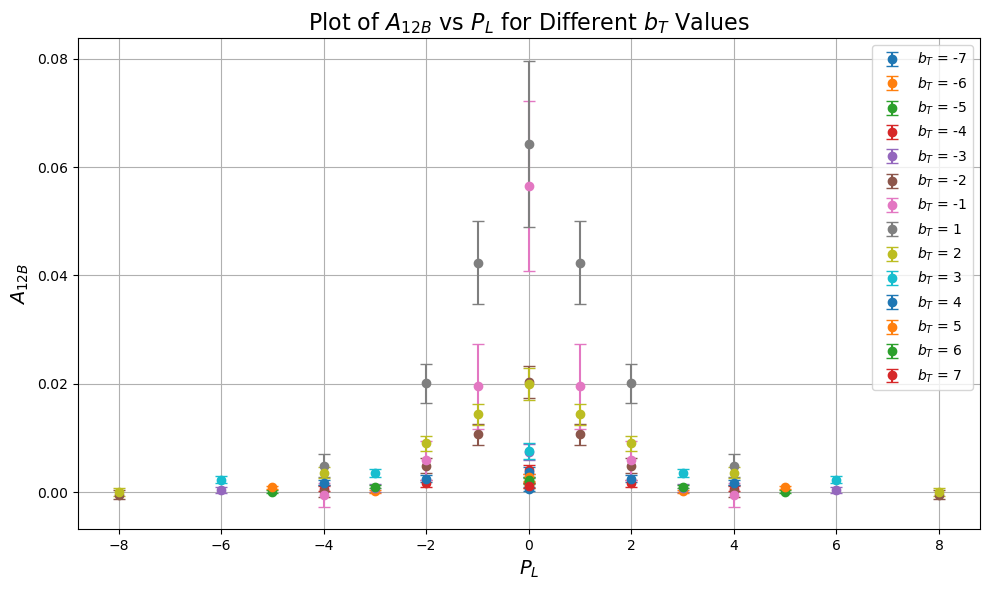

In [11]:

# Extract unique bT values
unique_bT = np.unique(bLbT[:, 1])

# Create the plot
plt.figure(figsize=(10, 6))

for i, bT in enumerate(unique_bT):
    #if bT<1 :
    #    continue
    # Filter data for the current bT value
    mask = bLbT[:, 1] == bT
    bL_values = bLbT[mask, 0]
    A12B_values = A12B[mask]
    A12B_errors = A12Berr[mask]

    # Plot with error bars
    plt.errorbar(
        bL_values,
        A12B_values,
        yerr=A12B_errors,
        fmt='o',
        label=f"$b_T$ = {int(bT)}",
        capsize=4
    )
# Add labels, legend, and grid
plt.xlabel("$P_{L}$", fontsize=14)
plt.ylabel("$A_{12B}$", fontsize=14)
plt.title("Plot of $A_{12B}$ vs $P_L$ for Different $b_T$ Values", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


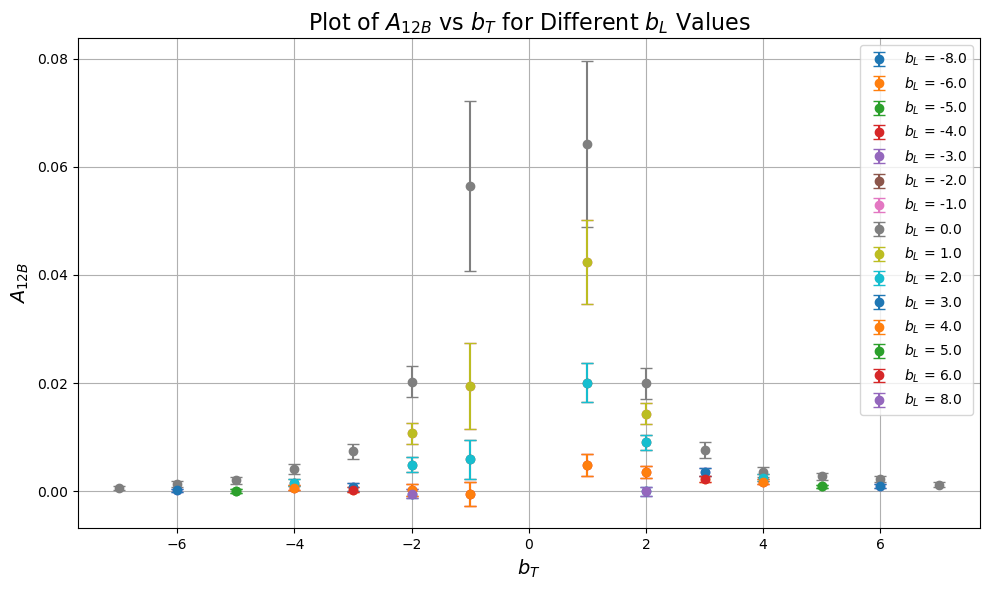

In [12]:
# Extract unique bT values
unique_bL = np.unique(bLbT[:, 0])

# Create the plot
plt.figure(figsize=(10, 6))

for i, bL in enumerate(unique_bL):
    #if bT<1 :
    #    continue
    # Filter data for the current bT value
    mask = bLbT[:, 0] == bL
    bT_values = bLbT[mask, 1]
    A12B_values = A12B[mask]
    A12B_errors = A12Berr[mask]

    # Plot with error bars
    plt.errorbar(
        bT_values,
        A12B_values,
        yerr=A12B_errors,
        fmt='o',
        label=f"$b_L$ = {bL}",
        capsize=4
    )
# Add labels, legend, and grid
plt.xlabel("$b_T$", fontsize=14)
plt.ylabel("$A_{12B}$", fontsize=14)
plt.title("Plot of $A_{12B}$ vs $b_T$ for Different $b_L$ Values", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


By default, we will set up 30 populations of expressions (which evolve independently except for migrations), use 4 threads, and use `"best"` for our model selection strategy:

In [14]:
default_pysr_params = dict(
    populations=30,
    model_selection="best",
)

In [15]:
#working wmse
#from sympy import exp, symbols, Function

#custom_loss_function = """
#function eval_loss(tree, dataset::Dataset{T,L}, options)::L where {T,L}
#    prediction, flag = eval_tree_array(tree, dataset.X, options)
#    if !flag
#        return L(Inf)
#    end
#    wmse = sum(dataset.weights .* (prediction .- dataset.y) .^ 2) / (dataset.n .* sum(dataset.weights))
#    return wmse
#end
#"""

#extra_sympy_mappings = {
#    "f": lambda Pb: Pb,  # Define f(Pb) as an identity for now (can be more complex)
#    "g": lambda bsq: bsq,  # Define g(bsq) similarly
#    "Lorentzian": lambda x, y: 1 / (y + x**2),
#    "gaussian": lambda x: exp(-x**2),
#    "decay": lambda x: exp(-x)
#}

#model = PySRRegressor(
#    niterations=30,
#    binary_operators=["*", "Lorentzian(x, y) = 1/(y + x^2)"],
#    unary_operators=["gaussian(x) = exp(-x^2)", "decay(x) = exp(-x)"],
#    extra_sympy_mappings=extra_sympy_mappings,  # Include the custom mappings
#    loss_function=custom_loss_function  # Use the custom loss function
#)

#model.fit(Pbbsq, A12B, weights=A12Bweight, variable_names=['Pb', 'bsq'])

modelold = PySRRegressor(
    niterations=50,
    unary_operators=["gaussian(x) = exp(-x^2)", "decay(x) = exp(-x)"],
    binary_operators=["*", "Lorentzian(x, y) = 1/(y + x^2)"],
    extra_sympy_mappings=extra_sympy_mappings,  # Include the custom mappings
    loss_function=custom_loss_function,  # Use the custom loss function
    nested_constraints = { "gaussian": {"gaussian": 0, "Lorentzian": 0, "decay": 0},"Lorentzian": {"Lorentzian": 0, "gaussian": 0, "decay": 0},  "decay": {"Lorentzian": 0, "gaussian": 0, "decay": 0}},
    constraints={'gaussian': (-1, 1), 'Lorentzian': (-1, 1), 'decay': (-1, 1)}

)

In [123]:
from sympy import exp, symbols, Function

custom_loss_function = """
using Symbolics

function eval_loss(tree, dataset::Dataset{T,L}, options)::L where {T,L}
    prediction, flag = eval_tree_array(tree, dataset.X, options)
    if !flag
        return L(Inf)
    end
    
    wmse = sum(dataset.weights .* (prediction .- dataset.y) .^ 2) / (dataset.n * sum(dataset.weights))
    return wmse
end
"""

extra_sympy_mappings = {
    "Lorentzian": lambda x, y: 1 / (y + x**2),
    "gaussian": lambda x: exp(-x**2),
    "decay": lambda x: exp(-x),
    "beta": lambda x, a, b: ((1 + x)**(a - 1) * (1 - x)**(b - 1)) 
}

modelold = PySRRegressor(
    niterations=50,
    unary_operators=["gaussian(x) = exp(-x^2)", "decay(x) = exp(-x)"],
    binary_operators=["*", "Lorentzian(x, y) = 1/(y + x^2)"],
    extra_sympy_mappings=extra_sympy_mappings,  # Include the custom mappings
    loss_function=custom_loss_function,  # Use the custom loss function
    nested_constraints = { "gaussian": {"gaussian": 0, "Lorentzian": 0, "decay": 0},"Lorentzian": {"Lorentzian": 0, "gaussian": 0, "decay": 0},  "decay": {"Lorentzian": 0, "gaussian": 0, "decay": 0}},
    constraints={'gaussian': (-1, 1), 'Lorentzian': (-1, 1), 'decay': (-1, 1)}

)

model = PySRRegressor(
    niterations=30,
    #unary_operators=["^"],
    binary_operators=["*", "+", "^"],
    extra_sympy_mappings=extra_sympy_mappings,  # Include the custom mappings
    #loss_function=custom_loss_function,  # Use the custom loss function
    #nested_constraints = { "gaussian": {"gaussian": 0}},
    constraints={'^': (-1, 1)}

)

model.fit(bLbT, A12B, weights=A12Bweight, variable_names=['bL', 'bT'])



/opt/homebrew/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.210e+05
Progress: 754 / 930 total iterations (81.075%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.743e-06  1.594e+01  y = 0.0012734
5           3.544e-06  1.366e-02  y = (bT * 9.0364e-05) + 0.0012793
7           3.166e-06  5.636e-02  y = ((bT * bT) ^ -0.58772) * 0.0066734
9           2.907e-06  4.275e-02  y = 0.0065421 * ((bT * (bT + -0.70048)) ^ -0.58766)
11          8.043e-07  6.424e-01  y = (((bT * bT) + (bL * bL)) ^ -1.1926) * 0.080836
13          7.123e-07  6.073e-02  y = 0.080688 * ((((-0.26495 + bT) * bT) + (bL * bL)) ^ -1....
                                      1918)
15          3.030e-07  4.274e-01  y = (((bT * bT) + (bL * ((0.7319 ^ bT) * bL))) ^ -1.1746) ...
                                      * 0.077709
17          2.732e-

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                       0.0012734458   
	1         0.013661                  (bT * 9.036428e-5) + 0.0012792958   
	2         0.056363            ((bT * bT) ^ -0.5877189) * 0.0066734087   
	3         0.045721  ((bT * (bT + -0.6927842)) ^ -0.5501066) * 0.00...   
	4         0.639436  (((bT * bT) + (bL * bL)) ^ -1.1943717) * 0.081...   
	5         0.063597  (((bL * bL) + ((bT + -0.26148063) * bT)) ^ -1....   
	6   >>>>  0.424557  (((bT * bT) + (bL * ((0.731905 ^ bT) * bL))) ^...   
	7         0.051633  ((((bT * bT) + ((0.76996154 ^ bT) * (bL * bL))...   
	8         0.010074  ((((bT * bT) + (((0.76996154 ^ bT) * bL) * (1....   
	9         0.002465  ((((((((0.77108115 ^ bT) * bL) * 1.039785) * b...   
	10        0.053722  ((((0.696213 ^ bT) * (bL * bL)) + ((bT + (bL *...   
	11        0.034177  (((bT * (bT + (bT * (bL * ((bL + 0.3042943) * ...   
	12        0.024729  ((((0.6959475 ^ bT) * (bL * bL)) + ((((((bL * ...   
	
	            loss  complexity  
	0   3.742883e-06           1  
	1   3.543846e-06           5  
	2   3.166054e-06           7  
	3   2.889384e-06           9  
	4   8.042623e-07          11  
	5   7.082040e-07          13  
	6   3.029654e-07          15  
	7   2.732407e-07          17  
	8   2.677908e-07          19  
	9   2.664741e-07          21  
	10  2.393275e-07          23  
	11  2.235150e-07          25  
	12  2.127293e-07          27  
]

  - outputs/20250326_155648_QUKTY2/hall_of_fame.csv


In [125]:
model.sympy(6)

0.077708595/(0.731905**bT*bL*bL + bT*bT)**1.1746309

We can also view the SymPy of any other expression in the list, using the index of it in `model.equations_`.

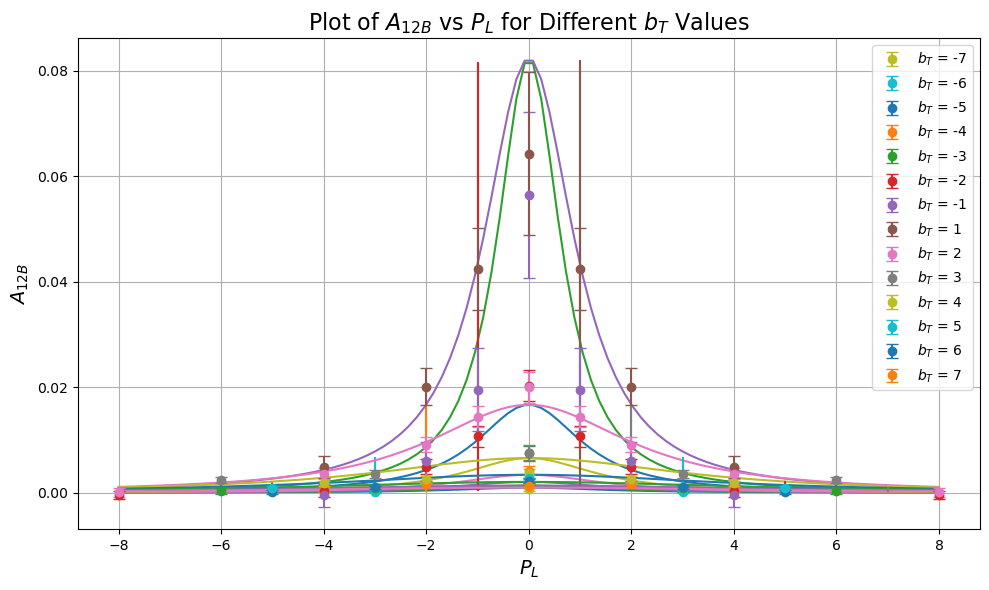

0.07928956/(0.6959475**bT*bL*bL + bT*((bL*bL - 1.1538901)*bT*0.20989832*0.13349019 + bT))**1.1530181

In [143]:
pick = 12


bL_plot = np.linspace(-8,8, 100)
plt.figure(figsize=(10, 6))

for bT in unique_bT:
    bLbT_plot = np.array([[bL, bT] for bL in bL_plot])
    predictions = model.predict(bLbT_plot, pick)
    plt.plot(bLbT_plot, predictions)
for i, bT in enumerate(unique_bT):
    #if bT<1 :
    #    continue
    # Filter data for the current bT value
    mask = bLbT[:, 1] == bT
    bL_values = bLbT[mask, 0]
    A12B_values = A12B[mask]
    A12B_errors = A12Berr[mask]

    # Plot with error bars
    plt.errorbar(
        bL_values,
        A12B_values,
        yerr=A12B_errors,
        fmt='o',
        label=f"$b_T$ = {int(bT)}",
        capsize=4
    )
# Add labels, legend, and grid
plt.xlabel("$P_{L}$", fontsize=14)
plt.ylabel("$A_{12B}$", fontsize=14)
plt.title("Plot of $A_{12B}$ vs $P_L$ for Different $b_T$ Values", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()



model.sympy(pick)

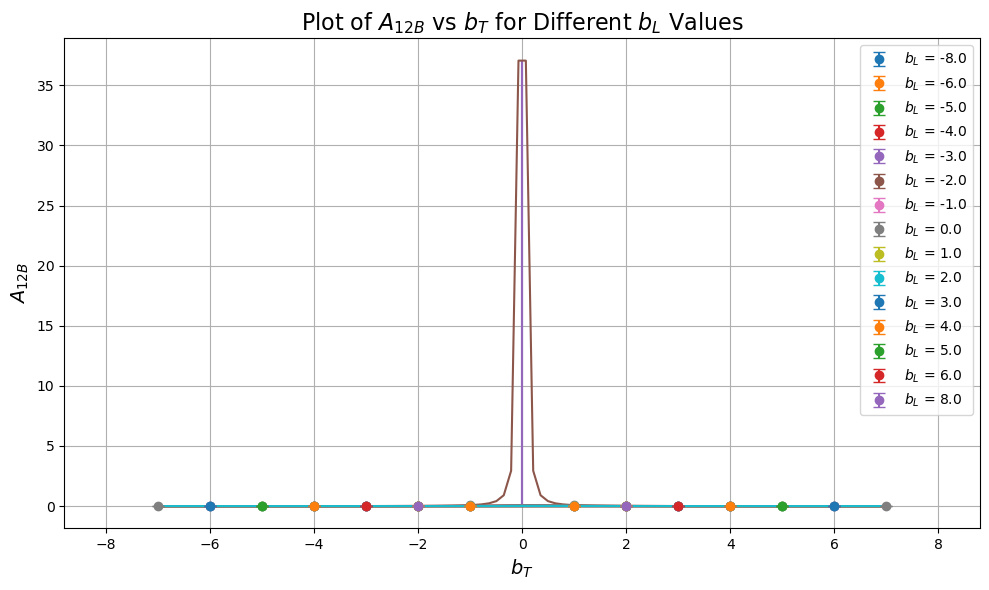

0.07928956/(0.6959475**bT*bL*bL + bT*((bL*bL - 1.1538901)*bT*0.20989832*0.13349019 + bT))**1.1530181

In [145]:

bT_plot = np.linspace(-7,7, 100)
plt.figure(figsize=(10, 6))

for bL in unique_bL:
    bLbT_plott = np.array([[bL, bT] for bT in bT_plot])
    predictions = model.predict(bLbT_plott, pick)
    plt.plot(bLbT_plott, predictions)

for i, bL in enumerate(unique_bL):
    #if bT<1 :
    #    continue
    # Filter data for the current bT value
    mask = bLbT[:, 0] == bL
    bT_values = bLbT[mask, 1]
    A12B_values = A12B[mask]
    A12B_errors = A12Berr[mask]

    # Plot with error bars
    plt.errorbar(
        bT_values,
        A12B_values,
        yerr=A12B_errors,
        fmt='o',
        label=f"$b_L$ = {bL}",
        capsize=4
    )
# Add labels, legend, and grid
plt.xlabel("$b_T$", fontsize=14)
plt.ylabel("$A_{12B}$", fontsize=14)
plt.title("Plot of $A_{12B}$ vs $b_T$ for Different $b_L$ Values", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

model.sympy(pick)


In [21]:
model.equations_[["complexity", "loss", "equation"]]

,complexity,loss,equation
0,1,0.000004,0.0012734579
1,6,0.000003,gaussian(bT * 0.22429886) * 0.003465547
2,8,0.000003,gaussian((bT * -0.061614037) * bL) * 0.0026988492
3,9,0.000003,gaussian(bT * 0.42850915) * (gaussian(bL) * 0....
4,11,0.000001,gaussian(bL * -0.36926478) * (gaussian(bT * 0....
